# Beehive monitoring

Notebook contributors: William Albert, Hannah Weiser, Ronald Tabernig, July 2025 

This notebook demonstrates the preparation of the beehive monitoring example, including the bee detection workflow. The dataset contains **6 LiDAR scans** of a beehive and the surrounding, each captured every 40 seconds on 14 May 2025.

For our use case, a point cloud **mask** was created containing the background points, i.e., all points not reflected from the flying bees. To speed up processing, the background points in each epoch were thinned using spatial subsampling (0.01 m), while the bee points were kept at their original resolution.

**Related publication:**
- Meyer, J. S., Tabernig, R., & Höfle, B. (2025). Detection of honey bees (*Apis mellifera*) in hypertemporal LiDAR point cloud time series to extract bee activity zones and times. ISPRS Annals of the Photogrammetry, Remote Sensing and Spatial Information Sciences, X-G-2025, 583–590. https://doi.org/10.5194/isprs-annals-x-g-2025-583-2025

## Imports

In [ ]:
import vapc
import numpy as np
import os
import sys
import json
sys.path.insert(0, "../src")
from fourdgeo import projection
from fourdgeo import utilities

# File download and handling
from pathlib import Path
import pooch
from tqdm import tqdm

# Clustering
from sklearn.cluster import DBSCAN

# Image handling
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont, ImageSequence
from shapely.geometry import shape

# Random Classification
import random

vapc.enable_trace(False)
vapc.enable_timeit(False)

## Get the data

In [2]:
# Handle file download/reading here
data_url = "https://heibox.uni-heidelberg.de/f/0ecf5340ade347548877/?dl=1"
data_hash = "ae229b9f870cd102d6aebaf9f75cf775049759ac3d75edfda8f596705a8e45b8"
file_name = "beehive.zip"
data_folder = "data/beehive"

if not Path(data_folder).exists():
    fnames = pooch.retrieve(url=data_url,
                            known_hash=data_hash,
                            path="./",
                            fname=file_name,
                            processor=pooch.Unzip(extract_dir=data_folder),
                            progressbar=True)
    os.remove(file_name)

## Bee detection

For the bee detection, we first isolate the bees from the rest of the scene by masking the trees, beehive, ground, etc. using the provided point cloud mask (`mask.laz`). Then, we cluster the bee points using [DBSCAN](https://www.dbs.ifi.lmu.de/Publikationen/Papers/KDD-96.final.frame.pdf) and write out the clustered point clouds.

In [3]:
observations = {"observations": []}
cluster_files = []

# Gather & sort only the .laz files
laz_paths = list(Path(data_folder).glob("*[!k].laz")) # Get all the files except the mask
laz_paths = sorted(laz_paths)

voxel_size = 0.05

dh_mask = vapc.DataHandler(Path(data_folder) / "mask.laz")
dh_mask.load_las_files()

vp_mask = vapc.Vapc(voxel_size=voxel_size, return_at="center_of_voxel")
vp_mask.get_data_from_data_handler(dh_mask)
vp_mask.voxel_index = False

for epoch_id, laz_path in enumerate(laz_paths):
    dh_epoch = vapc.DataHandler(laz_path)
    dh_epoch.load_las_files()
    dh_epoch.df = dh_epoch.df.loc[:, ['X','Y','Z','intensity','gps_time']]  # Only keeping xyz, intensity and GPS time

    ## 1. Isolate the bees
    vp_epoch = vapc.Vapc(voxel_size=voxel_size, return_at="center_of_voxel")
    vp_epoch.get_data_from_data_handler(dh_epoch)
    vp_epoch.select_by_mask(vp_mask, segment_in_or_out="out")    # <-- select_by_mask "out"
    dh_epoch.df = vp_epoch.df

    masked_pc_path = os.path.join(f"out/beehive/masked_{epoch_id:02d}_vox_{int(voxel_size*1000):03d}.laz")
    dh_epoch.save_as_las(masked_pc_path)

    ## 2. Spatial clustering
    coords = dh_epoch.df[["X", "Y", "Z"]].to_numpy()
    clustering = DBSCAN(eps=0.1, min_samples=4).fit(coords)
    cluster = clustering.labels_
    dh_epoch.df["cluster"] = cluster
    dh_epoch.df = dh_epoch.df[dh_epoch.df.cluster != -1]    # Dropping the points with a cluster value of -1
    outfile = masked_pc_path.replace(".laz", "_clustered.laz")
    dh_epoch.save_as_las(outfile)
    cluster_files.append(outfile)

## Projections (background point cloud)
### Prepare the configuration file

We use a configuration dictionary that contains general project settings like the `output_folder` and the relevant settings for the point cloud projection. For the projection, parameters like the `camera_position` and the `resolution_cm` are essential.

In [4]:
configuration = {
    "project_setting": {
        "project_name": "Beehive",
        "output_folder": "./out/beehive",
        "temporal_format": "%y%m%d_%H%M%S",
        "silent_mode": True,
        "include_timestamp": False
    },
    "pc_projection": {
        "pc_path": "",
        "make_range_image": True,
        "make_color_image": False,
        "top_view": False,
        "save_rot_pc": False,
        "resolution_cm": 1.0,
        "camera_position": [
            0.0,
            0.0,
            0.0
        ],
        "rgb_light_intensity": 100,
        "range_light_intensity": 10,
        "epsg": None
    }
}

### Generate the background image

We now generate the background image. For this, we are using classes and functions from the `fourdgeo` library. The class `PCloudProjection` directly takes our configuration file as input and writes the generated image to our specified `output_folder`.

In [5]:
pc = laz_paths[0]

dh_epoch = vapc.DataHandler(pc)
dh_epoch.load_las_files()

# Get the background scene
vp_epoch = vapc.Vapc(voxel_size=voxel_size)
vp_epoch.get_data_from_data_handler(dh_epoch)
vp_epoch.select_by_mask(vp_mask, segment_in_or_out="in")    # <-- select_by_mask "in"
dh_epoch.df = vp_epoch.df

bg_pc_path = os.path.join(f"out/beehive/background_pc.laz")
dh_epoch.save_as_las(bg_pc_path)

configuration['pc_projection']['pc_path'] = bg_pc_path
project_name = configuration['project_setting']['project_name']
output_folder = configuration['project_setting']['output_folder']


In [ ]:

background_projection = projection.PCloudProjection(
    configuration = configuration,
    project_name = project_name,
    projected_image_folder = output_folder,
)
(
    ref_h_fov, ref_v_fov, ref_anchor_point_xyz, 
    ref_h_img_res, ref_v_img_res
) = background_projection.project_pc(buffer_m = 0.25)

bg_img = background_projection.bg_image_filename[0]

### Convert .tif Image to .png Image

Because the dashboard (currently) does not support TIF files, we need to convert the generated background image to the PNG format.

In [7]:
image_path = background_projection.bg_image_filename[0]
filename = str.split(image_path, ".tif")[0]
try:
    with Image.open(image_path) as im:
        for i, page in enumerate(ImageSequence.Iterator(im)):
            out_path = filename + ".png"
            if not os.path.isfile(out_path):
                try:
                    page.save(out_path)
                except:
                    print(out_path)
        png_image = out_path
except:
    print(filename)

### Dispay the background image

Let's have a look at how the point cloud looks like from the scanner view.

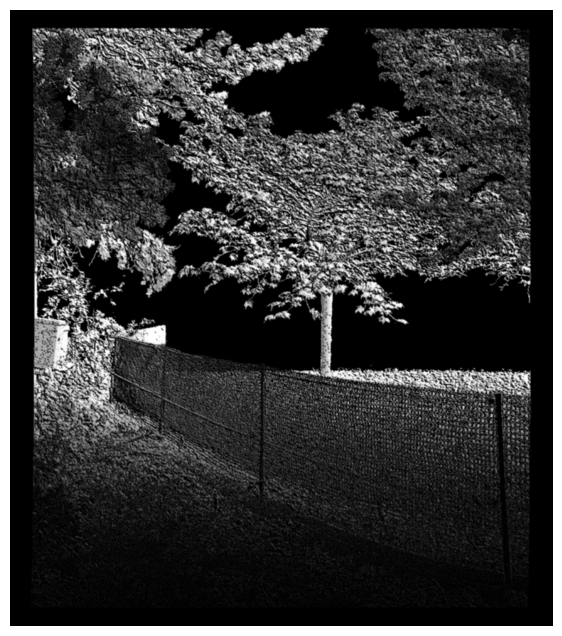

In [8]:
img_path = r"../docs/out/beehive/Beehive_RangeImage.tif"

# Load and display TIFF image
img = Image.open(img_path)
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

## Projections (bee observations)

We describe each bee cluster by its centroid. In the following, we extract the center point for each center and create `geoObjects`, one for each cluster. For the purpose of showcasing, we randomly assign each extracted geoObject either the `Bee` or `Hornet` type.

In [ ]:
for epoch_id, cluster_file in enumerate(cluster_files):
    geoObjects = []
    dh_cluster = vapc.DataHandler(cluster_file)
    dh_cluster.load_las_files()

    # get cluster center from each cluster (each bee)
    cluster_centers = dh_cluster.df.groupby('cluster').mean().reset_index().to_numpy()
    columns = dh_cluster.df.groupby('cluster').mean().reset_index().columns
    cluster_idx = columns.get_loc('cluster')
    intensity_idx = columns.get_loc('intensity')
    gps_time_idx = columns.get_loc('gps_time')

    # extract time from filename
    t_min = t_max = utilities.iso_timestamp(laz_paths[epoch_id].stem.split(" ")[-3])

    # create json object for each line
    for i, cluster_center in enumerate(cluster_centers):
        geoObject = {}
        geoObject["id"] = f"{epoch_id}{i:04d}"
        geoObject["type"] = random.choices(["Bee", "Hornet"], weights=[0.97, 0.03])[0]
        geoObject["dateTime"] = t_min
        geoObject["geometry"] = {
            "type": "",
            "coordinates": [
                cluster_center[1:4].tolist()
            ]
        }
        geoObject["customAttributes"] = {
            "cluster_id":  cluster_center[cluster_idx],
            "intensity": cluster_center[intensity_idx],
            "gps_time": cluster_center[gps_time_idx],
            "epoch_id": epoch_id
        }
        
        geoObjects.append(geoObject)

    observations["observations"].append({
        "startDateTime": t_min,
        "endDateTime": t_max,
        "geoObjects": geoObjects,
        "backgroundImageData": {
            "url": bg_img,
            "height": Image.open(bg_img).convert("RGB").size[1],
            "width": Image.open(bg_img).convert("RGB").size[0]
        },
    })

### Project the bee clusters onto the image background

Here, we project the bee observations onto the background image using the `ProjectChange` class. The `observation` GeoJSON files are written to the `output_folder`.

In [ ]:
from fourdgeo import projection
list_observation_projection = []
for epoch_id, observation in enumerate(observations['observations']):
    observation_projection = projection.ProjectChange(observation=observation,
                            project_name=f"{project_name}_{epoch_id}_{epoch_id+1}",
                            projected_image_path=background_projection.bg_image_filename[0],
                            projected_events_folder=output_folder,
                            epsg=None)

    observation_projection.project_change()
    list_observation_projection.append(observation_projection)

### Display the bee clusters in the site

Finally, we generate a GIF of the time series and display the bee clusters using the projected points.

In [11]:
frames = []
gif_path = "../docs/img/beehive_projections_plus_observations.gif"
font = ImageFont.load_default(size = 50)
ellipse_size = 8

for enum, observation_projection in enumerate(list_observation_projection):
    frm = Image.open(bg_img).convert("RGB")
    draw = ImageDraw.Draw(frm)
    draw.text((50, 1300), f"Epoch: {enum}", fill=(255, 255, 255), font=font)

    # Load geojson
    with open(observation_projection.geojson_name, 'r') as f:
        geojson_data = json.load(f)

    for feature in geojson_data["features"]:
        geom = shape(feature["geometry"])
        
        coords = [(int(x), -int(y)) for x, y in geom.coords]

        x, y = geom.coords[0][0], geom.coords[0][1] * -1
        draw.ellipse([x-ellipse_size//2, y-ellipse_size//2, x+ellipse_size//2, y+ellipse_size//2], fill="yellow")

    frames.append(frm)
    

frames[0].save(
    gif_path,
    save_all=True,
    append_images=frames[1:],
    duration=600,
    loop=0
)

<img src="img/beehive_projections_plus_observations.gif" style="height:900px;">

## Extract the final JSON 

In order to include this data into the dashboard, we now need to convert the created geojson data to the dashboard data model. For this, we iterate through all geojson files and create their observation objects and the aggregate them into one final data model object and store it in the `output_folder`. This files can then be loaded with the 4DGeo Dashboard.

Note: The path to the background image files has to be a working url. In this example, we use the temporary hosted localhost, explained in [this section](#visualise-the-data-in-the-dashboard). Later this can and should be replaced by an actual server containing the files.

In [12]:
aggregated_data = utilities.DataModel([])

for (i, observation_projection) in enumerate(list_observation_projection):
    if observation_projection is None:
        continue
    elif observation_projection.observation["geoObjects"] is None:
        img_size = Image.open(png_image).convert("RGB").size
        aggregated_data.observations.append(utilities.Observation(
            startDateTime=observation_projection.observation["startDateTime"],
            endDateTime=observation_projection.observation["endDateTime"],
            geoObjects=[],
            backgroundImageData=utilities.ImageData(
                url=str("http://localhost:8001/" + png_image).replace("\\", "/"),
                width=img_size[0],
                height=img_size[1]
            )
        ))
        continue
    
    with open(observation_projection.geojson_name, 'r') as f:
        geojson_data = json.load(f)
    
    img_size = Image.open(png_image).convert("RGB").size
    geometry = geojson_data.get("features")[0].get("geometry")
    coords = geometry.get("coordinates")
    new_observations = utilities.convert_geojson_to_datamodel(
        geojson=geojson_data,
        bg_img=str("http://localhost:8001/" + png_image).replace("\\", "/"),
        width=img_size[0],
        height=img_size[1]
    )

    aggregated_data.observations.extend(new_observations.observations)

with open(f"{output_folder}/final_data_model.json", "w") as f:
    f.write(aggregated_data.toJSON())

### Visualise the data in the dashboard

To see our results in the actual dashboard, we need to host the created json file to make it accessbile. As a quick and easy solution, we can use the **http.server** python library. The python script `server-host.py` hosts all the files in this directory. So in order to setup this local hosting, we need navigate to the `4DGeo/docs` folder to execute the following command in a commandline:

`python server_host.py`

Lastly, inside of the dashboard, set the data source to `http://localhost:8001/out/rockfall_monitoring/final_data_model.json`.